# Question 1
Gaurav anand(213079019)
Manuraj P M(213230012)

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
from google.colab import drive

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


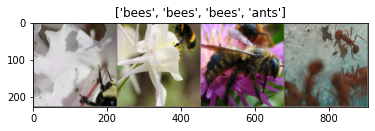

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5667 Acc: 0.7172
val Loss: 0.2022 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4094 Acc: 0.8279
val Loss: 0.2104 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5127 Acc: 0.7500
val Loss: 0.3429 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.3857 Acc: 0.8402
val Loss: 0.2680 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3703 Acc: 0.8607
val Loss: 0.3064 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3302 Acc: 0.8607
val Loss: 0.3160 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.5148 Acc: 0.7951
val Loss: 0.2703 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3164 Acc: 0.8811
val Loss: 0.2606 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3460 Acc: 0.8770
val Loss: 0.1949 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2572 Acc: 0.8770
val Loss: 0.2117 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3242 Acc: 0.8648
val Loss: 0.2009 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3206 Acc: 0.8648
val Loss: 0.1898 Acc: 0.9281

Epoch 12/24
----------
t

In [ ]:
validation_loss=[ 0.2022,0.2104,0.3429,0.2680,0.3064,0.3160,0.2703,0.2606,0.1949,0.2117,0.2009,0.1898,0.1863,0.2750,0.1954, 0.2372,0.2272,0.2047,0.2113,0.1917,0.1908,0.1949,0.1876,0.2018,0.1890]
accuracy = [ 0.9346,0.9346,0.8693,0.8889,0.8889,0.8431,0.9281,0.8954,0.9150,0.9281,0.9281,0.9281,0.9346,0.9150,0.9346,0.9281,0.9346,0.9346,0.9346,0.9346,0.9346,0.9346,0.9216,0.9281,0.9216]
number_of_epochs =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]


In [ ]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


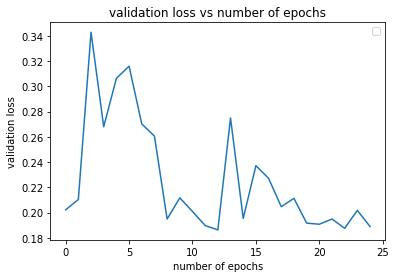

In [ ]:
plt.plot(number_of_epochs,validation_loss)
plt.xlabel("number of epochs")
plt.ylabel("validation loss")
plt.title("validation loss vs number of epochs")
plt.legend()
plt.show()

No handles with labels found to put in legend.


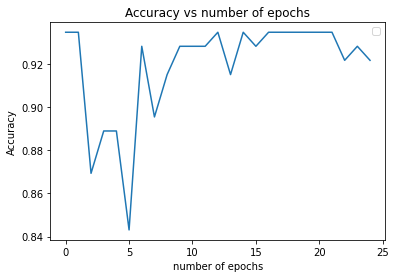

In [ ]:
plt.plot(number_of_epochs,accuracy)
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of epochs")
plt.legend()
plt.show()

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00098, momentum=0.8975)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6979 Acc: 0.6844
val Loss: 0.2858 Acc: 0.8824

Epoch 1/19
----------
train Loss: 0.5993 Acc: 0.7459
val Loss: 0.3097 Acc: 0.9020

Epoch 2/19
----------
train Loss: 0.4763 Acc: 0.7910
val Loss: 0.2966 Acc: 0.8627

Epoch 3/19
----------
train Loss: 0.5630 Acc: 0.7377
val Loss: 0.4497 Acc: 0.8235

Epoch 4/19
----------
train Loss: 0.6084 Acc: 0.7869
val Loss: 0.3609 Acc: 0.8758

Epoch 5/19
----------
train Loss: 0.4251 Acc: 0.8279
val Loss: 0.5013 Acc: 0.8431

Epoch 6/19
----------
train Loss: 0.4766 Acc: 0.7992
val Loss: 0.3028 Acc: 0.9020

Epoch 7/19
----------
train Loss: 0.3350 Acc: 0.8443
val Loss: 0.2607 Acc: 0.9216

Epoch 8/19
----------
train Loss: 0.5151 Acc: 0.7869
val Loss: 0.2121 Acc: 0.9150

Epoch 9/19
----------
train Loss: 0.3344 Acc: 0.8361
val Loss: 0.2199 Acc: 0.9216

Epoch 10/19
----------
train Loss: 0.2828 Acc: 0.8811
val Loss: 0.1870 Acc: 0.9412

Epoch 11/19
----------
train Loss: 0.3331 Acc: 0.8484
val Loss: 0.1814 Acc: 0.9477

Epoch 12/19
----------
t

In [ ]:
validation_loss_2 =[0.2858,0.3097,0.2966,0.4497,0.3609,0.5013,0.3028,0.2607,0.2121,0.2199,0.1870,0.1814,0.1900,0.1963,0.1877,0.2160,0.2011,0.2225,0.1921,0.2013]
accuracy_2=[0.8824,0.9020,0.8627,0.8235,0.8758,0.8431,0.9020,0.9216,0.9150,0.9216,0.9412,0.9477,0.9346,0.9477,0.9412,0.9346,0.9346,0.9150,0.9346,0.9477]
number_of_epochs_2 =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

No handles with labels found to put in legend.


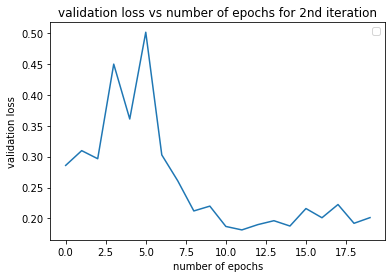

In [ ]:
plt.plot(number_of_epochs_2,validation_loss_2)
plt.xlabel("number of epochs")
plt.ylabel("validation loss")
plt.title("validation loss vs number of epochs for 2nd iteration")
plt.legend()
plt.show()

No handles with labels found to put in legend.


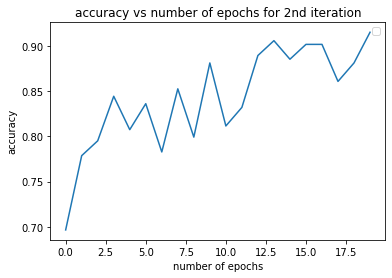

In [ ]:
plt.plot(number_of_epochs_2,accuracy_2)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.title("accuracy vs number of epochs for 2nd iteration")
plt.legend()
plt.show()

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00102, momentum=0.90025)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4421 Acc: 0.7992
val Loss: 0.3092 Acc: 0.8562

Epoch 1/19
----------
train Loss: 0.4400 Acc: 0.8238
val Loss: 0.2181 Acc: 0.9412

Epoch 2/19
----------
train Loss: 0.2690 Acc: 0.8730
val Loss: 0.1959 Acc: 0.9346

Epoch 3/19
----------
train Loss: 0.4715 Acc: 0.7910
val Loss: 0.2687 Acc: 0.8954

Epoch 4/19
----------
train Loss: 0.4319 Acc: 0.8115
val Loss: 0.2875 Acc: 0.9216

Epoch 5/19
----------
train Loss: 0.5962 Acc: 0.8033
val Loss: 0.4222 Acc: 0.8431

Epoch 6/19
----------
train Loss: 0.6047 Acc: 0.8074
val Loss: 0.6140 Acc: 0.7974

Epoch 7/19
----------
train Loss: 0.4848 Acc: 0.8279
val Loss: 0.3388 Acc: 0.8497

Epoch 8/19
----------
train Loss: 0.3931 Acc: 0.8197
val Loss: 0.3286 Acc: 0.8562

Epoch 9/19
----------
train Loss: 0.3730 Acc: 0.8443
val Loss: 0.2466 Acc: 0.9020

Epoch 10/19
----------
train Loss: 0.3747 Acc: 0.8443
val Loss: 0.2708 Acc: 0.8693

Epoch 11/19
----------
train Loss: 0.3849 Acc: 0.8320
val Loss: 0.2828 Acc: 0.8758

Epoch 12/19
----------
t

In [ ]:
validation_loss_3=[0.3092,0.2181,0.1959,0.2687,0.2875,0.4222,0.6140,0.3388,0.3286,0.2466,0.2708,0.2828,0.2818,0.2422,0.2253,0.2186,0.2062,0.2156,0.2335,0.2224]
accuracy_3 = [0.8562,0.9412,0.9346,0.8954,0.9216,0.8431,0.7974,0.8497,0.8562,0.9020,0.8693,0.8758,0.8889,0.9085,0.9150,0.9216,0.9281,0.9281,0.9085,0.9216]
number_of_epochs_3 =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

No handles with labels found to put in legend.


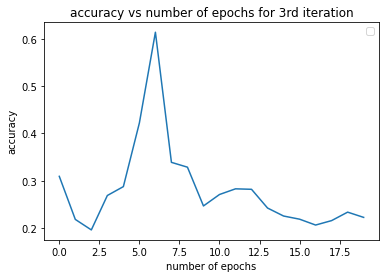

In [ ]:
plt.plot(number_of_epochs_3,validation_loss_3)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.title("accuracy vs number of epochs for 3rd iteration")
plt.legend()
plt.show()

No handles with labels found to put in legend.


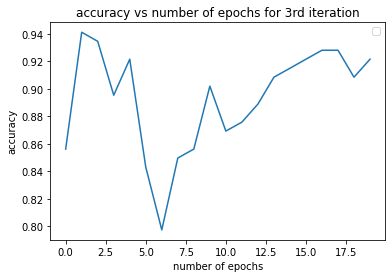

In [ ]:
plt.plot(number_of_epochs_3,accuracy_3)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.title("accuracy vs number of epochs for 3rd iteration")
plt.legend()
plt.show()

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.88)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8154 Acc: 0.6967
val Loss: 0.2837 Acc: 0.9216

Epoch 1/9
----------
train Loss: 0.4725 Acc: 0.7910
val Loss: 0.2221 Acc: 0.9281

Epoch 2/9
----------
train Loss: 0.6201 Acc: 0.7623
val Loss: 0.3300 Acc: 0.8693

Epoch 3/9
----------
train Loss: 0.6394 Acc: 0.7459
val Loss: 0.2644 Acc: 0.8954

Epoch 4/9
----------
train Loss: 0.5392 Acc: 0.7623
val Loss: 0.3516 Acc: 0.8627

Epoch 5/9
----------
train Loss: 0.4020 Acc: 0.8525
val Loss: 0.4744 Acc: 0.8039

Epoch 6/9
----------
train Loss: 0.6403 Acc: 0.7992
val Loss: 0.2474 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.3351 Acc: 0.8689
val Loss: 0.2263 Acc: 0.9216

Epoch 8/9
----------
train Loss: 0.2851 Acc: 0.8689
val Loss: 0.2294 Acc: 0.9150

Epoch 9/9
----------
train Loss: 0.3547 Acc: 0.8607
val Loss: 0.2232 Acc: 0.9412

Training complete in 1m 2s
Best val Acc: 0.941176


In [ ]:
validation_loss_4 =[0.2837,0.2221,0.3300,0.2644,0.3516,0.4744,0.2474,0.2263,0.2294,0.2232 ]
accuracy_4 = [0.9216,0.9281,0.8693,0.8954,0.8627,0.8039,0.9085,0.9216,0.9150,0.9412]
number_of_epochs_4=[0,1,2,3,4,5,6,7,8,9]

No handles with labels found to put in legend.


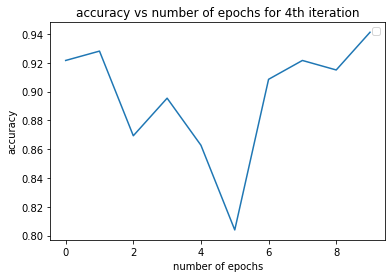

In [ ]:
plt.plot(number_of_epochs_4,accuracy_4)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.title("accuracy vs number of epochs for 4th iteration")
plt.legend()
plt.show()

No handles with labels found to put in legend.


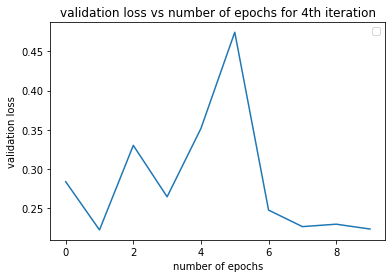

In [ ]:
plt.plot(number_of_epochs_4,validation_loss_4)
plt.xlabel("number of epochs")
plt.ylabel("validation loss")
plt.title("validation loss vs number of epochs for 4th iteration")
plt.legend()
plt.show()